<img src="../images/logos/ClimKern-logo.png" width=250 alt="ClimKern Python Package Logo"></img>

# Feedbacks with ClimKern

---

## Overview

While it is good to know how to manually calculate radiative feedbacks, it is also time-consuming to constantly recreate the code. Here, we will use a new Python package called ClimKern that offers functions to calculate radiative feedbacks from climate model or reanalysis output. The advantages of using ClimKern go beyond making it simpler—it standardizes the methods and assumptions that go into these sometimes complicated calculations. We will use CMIP6 output in this notebook. You will learn how to:

1. Download CMIP6 data from Pangeo's space on Google Cloud.
1. Obtain a radiative kernel from the ClimKern repository.
1. Calculate the surface albedo, temperature, and water vapor feedbacks.
1. Compute the cloud feedbacks using the two main methods: residual and adjustment.
1. Quantify stratospheric feedbacks.

## Prerequisites

| Concepts | Importance | Notes |
| --- | --- | --- |
| [Intro to Xarray](https://foundations.projectpythia.org/core/xarray/xarray-intro.html) | Necessary | |
| [Intro to Cartopy](https://foundations.projectpythia.org/core/cartopy/cartopy.html) | Necessary | |
| [Intro to Matplotlib](https://foundations.projectpythia.org/core/matplotlib/matplotlib-basics.html) | Helpful | |
| [Loading CMIP6 Data with Intake-ESM](https://projectpythia.org/cmip6-cookbook/notebooks/foundations/intake-esm.html) | Helpful | | 

- **Time to learn**: 20 minutes

---

## Imports

In [1]:
import climkern as ck
import intake
import matplotlib.pyplot as plt
import s3fs
import fsspec
import xarray as xr
import glob
import importlib.util
import os
import cartopy.crs as ccrs

%matplotlib inline
plt.rcParams["figure.dpi"] = 100

## Download the kernel

Normally, when ClimKern is installed, the user needs to download data on the command
line from the Zenodo repository. However, we now have the data on Jetstream2, so
we can download it from there and save it in our package repository.

<div class="admonition alert alert-info">
    <p class="admonition-title" style="font-weight:bold">Future update</p>
    Future versions of ClimKern will be able to pull the kernel from Jetstream2 without
    storing locally.
</div>

First, set the URL and path to point to ClimKern. Also, specify which kernel you want.

In [2]:
URL = "https://js2.jetstream-cloud.org:8001/" # URL for jetstream access
path = f"pythia/ClimKern" # Location of ClimKern
kernel = "ERA5"

Next, read in the data from Jetstream2

In [3]:
# Read in data
# Set up access to jetstream2
fs = fsspec.filesystem("s3", anon=True, client_kwargs=dict(endpoint_url=URL))
pattern = f"s3://{path}/kernels/"+kernel+f"/TOA*.nc"

# Grab the data
files = sorted(fs.glob(pattern))

# Open file and make it Xarray Dataset
kern = xr.open_dataset(fs.open(files[0]))

# Save path for later
path_out = files[0].split(kernel+"/",1)[1]

To save this data in ClimKern's directory, we have to figure out where it is on the
machine. After that, we will go ahead and save out the kernel as a netCDF in 
ClimKern's local data directory.

In [4]:
# Get the package location
spec = importlib.util.find_spec("climkern")
package_dir = os.path.dirname(spec.origin)

# print(f"The package directory is: {package_dir}")

# Define the path where you want to save the netCDF file within the package directory
netcdf_path = os.path.join(package_dir,"data/kernels",kernel,path_out)

# Ensure the directory exists
os.makedirs(os.path.dirname(netcdf_path), exist_ok=True)

# Save the dataset as a netCDF file
kern.to_netcdf(netcdf_path)

Now, let's just make sure we can retrieve the kernel.

In [5]:
ck.util.get_kern(kernel)

<xarray.Dataset> Size: 228MB
Dimensions:   (plev: 37, lat: 73, lon: 144, time: 12)
Coordinates:
  * plev      (plev) float32 148B 1e+03 975.0 950.0 925.0 ... 5.0 3.0 2.0 1.0
  * lat       (lat) float32 292B 90.0 87.5 85.0 82.5 ... -82.5 -85.0 -87.5 -90.0
  * lon       (lon) float32 576B 0.0 2.5 5.0 7.5 ... 350.0 352.5 355.0 357.5
  * time      (time) int64 96B 0 1 2 3 4 5 6 7 8 9 10 11
Data variables:
    lwclr_t   (time, plev, lat, lon) float64 37MB ...
    lw_t      (time, plev, lat, lon) float64 37MB ...
    lwclr_q   (time, plev, lat, lon) float64 37MB ...
    lw_q      (time, plev, lat, lon) float64 37MB ...
    swclr_q   (time, plev, lat, lon) float64 37MB ...
    sw_q      (time, plev, lat, lon) float64 37MB ...
    swclr_a   (time, lat, lon) float64 1MB ...
    sw_a      (time, lat, lon) float64 1MB ...
    lwclr_ts  (time, lat, lon) float64 1MB ...
    lw_ts     (time, lat, lon) float64 1MB ...

## Prepare the CMIP6 Data

To start, we will need some CMIP6 data to calculate feedbacks. We will use the
preindustrial control and 4×CO$_2$ experiments from just one model (CESM2).

In [6]:
# Make a list of variables and experiments we need
var_list = ["rsds","rsus","ta","ts","ps","hus"]
exp_list = ["piControl","abrupt-4xCO2"]

# Specify data location, open it
cat_url = "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"
col = intake.open_esm_datastore(cat_url)

# Create a catalog of matching simulations
cat = col.search(experiment_id=exp_list,source_id="CESM2",variable_id=var_list,
                table_id="Amon")

# Convert to a dictionary of Xarray Datasets
ds_dict = cat.to_dataset_dict(zarr_kwargs={'consolidated': True})


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


The data, especially the preindustrial control simulation that will serve as our
control climate, is huge. We are going to only use the last 50 years of the control
and last 30 years of the abrupt 4×CO$_2$ simulation. There are a few extra coordinates
and/or dimensions we don't need, hence the `squeeze()`.

In [7]:
# Our control simulation
ctrl = ds_dict["CMIP.NCAR.CESM2.piControl.Amon.gn"].isel(
    time=slice(-600,None)).squeeze().chunk({"plev":1,"time":-1})

# The increase CO2 aka "perturbed" simulation
pert = ds_dict["CMIP.NCAR.CESM2.abrupt-4xCO2.Amon.gn"].isel(
    time=slice(-360,None)).squeeze().chunk({"plev":1,"time":-1})

To save a little diskspace because ClimKern still isn't dask compatible yet,
let's make our control climatology ahead of time.

In [8]:
ctrl = ctrl.groupby(ctrl.time.dt.month).mean(dim="time").rename({"month":"time"})
pert = pert.groupby(pert.time.dt.month).mean(dim="time").rename({"month":"time"})

## Feedback calculations

### Calculate surface temperature change

ClimKern outputs feedbacks as radiative perturbations at the TOA (because there are multiple ways to quantify feedbacks). One of the most common ways is to normalize by the change in the surface temperature, which puts values in "true" feedback units of W/m$^2$/K. For that, we start by calculating the change in the surface temperature in our CESM2 experiment.

In [29]:
# Take difference between pert and ctrl ts fields
Δts = pert.ts - ctrl.ts

### Surface albedo feedback

Perhaps the simplest of the radiative feedbacks to calculate is the surface albedo
feedback because it requires only two variables and is a 3-dimensional field (no height
coordinate). The variables we will use are as follows:

| Variable name | Description | Units |
| --- | --- | --- |
|<i>rsus</i> | The upwelling shortwave radiation at the surface | W/m$^2$ |
|<i>rsds</i> | The downwelling shortwave radiation at the surface | W/m$^2$ |


The [`calc_alb_feedback()`](https://tyfolino.github.io/climkern/climkern.html#climkern.calc_alb_feedback) function is straightforward. Be sure to include our kernel name
in the arguments.

In [9]:
alb = ck.calc_alb_feedback(
    ctrl.rsus,ctrl.rsds,pert.rsus,pert.rsds,kern="ERA5"
)

Let's see what the resulting Dataarray looks like.

In [10]:
alb

<xarray.DataArray (time: 12, lat: 192, lon: 288)> Size: 5MB
dask.array<mul, shape=(12, 192, 288), dtype=float64, chunksize=(1, 192, 288), chunktype=numpy.ndarray>
Coordinates:
  * lat             (lat) float64 2kB -90.0 -89.06 -88.12 ... 88.12 89.06 90.0
  * lon             (lon) float64 2kB 0.0 1.25 2.5 3.75 ... 356.2 357.5 358.8
    member_id       <U8 32B 'r1i1p1f1'
    dcpp_init_year  float64 8B nan
  * time            (time) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12

Finally, let's plot the time average surface albedo feedback on a map, first as just the perturbation.

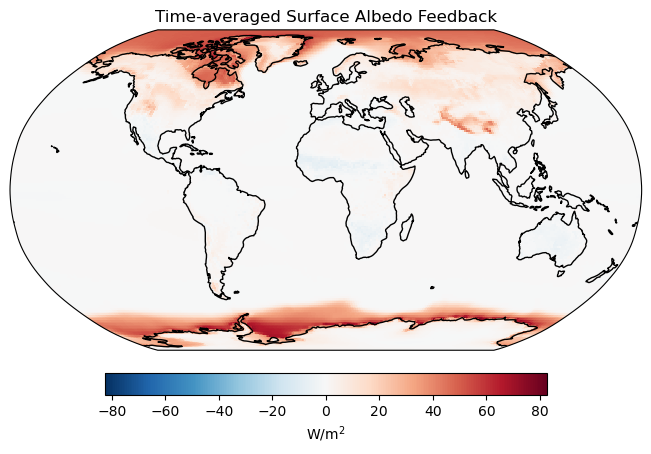

In [30]:
# Set a few variables
proj = ccrs.Robinson()

# Create figure and axis
fig, ax = plt.subplots(subplot_kw=dict(projection=proj),
                       layout="constrained")

# Plot surface albedo feedback & add coastlines
alb.mean(dim="time").plot(ax=ax,transform=ccrs.PlateCarree(),
                         cbar_kwargs={"orientation": "horizontal", "shrink": 0.7,
                                      "label":"W/m$^2$"})
ax.coastlines()

# Add a title
ax.set_title("Time-averaged Surface Albedo Feedback")

plt.show()

Now normalized by the surface temperature change...

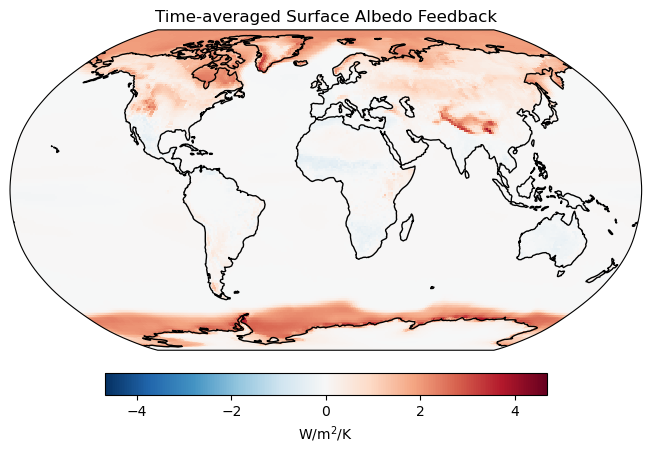

In [43]:
# Set a few variables
proj = ccrs.Robinson()

# Create figure and axis
fig, ax = plt.subplots(subplot_kw=dict(projection=proj),
                       layout="constrained")

# Plot surface albedo feedback & add coastlines
(alb.mean(dim="time")/Δts.mean(dim="time")).plot(ax=ax,transform=ccrs.PlateCarree(),
                         cbar_kwargs={"orientation": "horizontal", "shrink": 0.7,
                                      "label":"W/m$^2$/K"})
ax.coastlines()

# Add a title
ax.set_title("Time-averaged Surface Albedo Feedback")

plt.show()

As one might expect, the greatest radiative change at the TOA from the surface albedo feedback is near the poles where there is melting sea ice and snow.

Let's end by calculating the global average. ClimKern comes with a [`spat_avg()`](https://tyfolino.github.io/climkern/climkern.html#climkern.spat_avg) function.

In [59]:
# Output the time-averaged global surface albedo feedback
output = "The global average surface albedo feedback is {value:.2f} W/m\u00b2/K."
print(output.format(value=float(ck.spat_avg((alb.mean(dim="time")/Δts.mean(dim="time")
                                         ).expand_dims("time")))))

The global average surface albedo feedback is 0.23 W/m²/K.


### Planck and lapse rate feedbacks

As a reminder, the total tropospheric temperature feedback is often decomposed into a distict Planck and lapse rate feedback. ClimKern has a single function that produces both feedbacks simultaneously called [`calc_T_feedbacks()`](https://tyfolino.github.io/climkern/climkern.html#climkern.calc_T_feedbacks). The variables we need this time are:

| Variable name | Description | Units | Notes |
| --- | --- | --- | --- |
|<i>ta</i> | The 4-dimensional air temperature | K | |
|<i>ts</i> | The 3-dimensional surface skin temperature | K | |
|<i>ps</i> | The 3-dimensional surface pressure | Pa, mb, or hPa| |
|<i>trop_p</i> | The 3-dimensional tropopause height | Pa, mb, or hPa | <i>Optional</i> |

CMIP6 output rarely contains the tropopause height, so we will create a default tropopause that decreases linearly with the cosine of latitude from 100 hPa at the Equator to 300 hPa at the poles.

In [12]:
# Use ClimKern's "hidden" make_tropo function
pert["trop_p"] = ck.util.make_tropo(pert.ps)
pert.trop_p.attrs["units"] = "Pa"

lr,pl = ck.calc_T_feedbacks(
    ctrl.ta,ctrl.ts,ctrl.ps,pert.ta,pert.ts,pert.ps,pert_trop=pert.trop_p,kern="ERA5"
)

Simple. Let's see what it looks like.

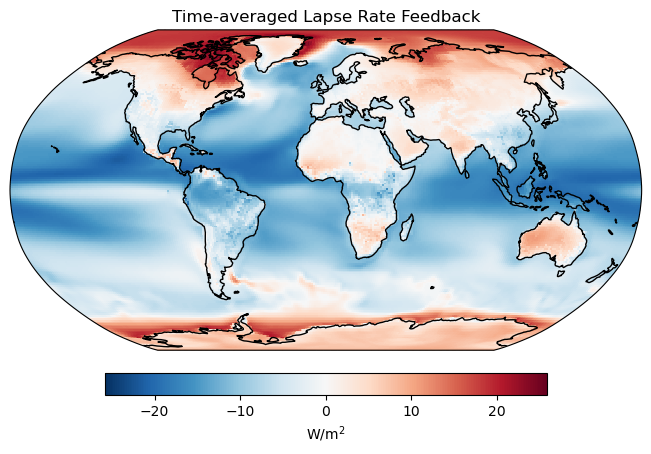

In [13]:
# Set a few variables
proj = ccrs.Robinson()

# Create figure and axis
fig, ax = plt.subplots(subplot_kw=dict(projection=proj),
                       layout="constrained")

# Plot surface albedo feedback & add coastlines
lr.mean(dim="time").plot(ax=ax,transform=ccrs.PlateCarree(),
                         cbar_kwargs={"orientation": "horizontal", "shrink": 0.7,
                                      "label":"W/m$^2$"})
ax.coastlines()

# Add a title
ax.set_title("Time-averaged Lapse Rate Feedback")

plt.show()

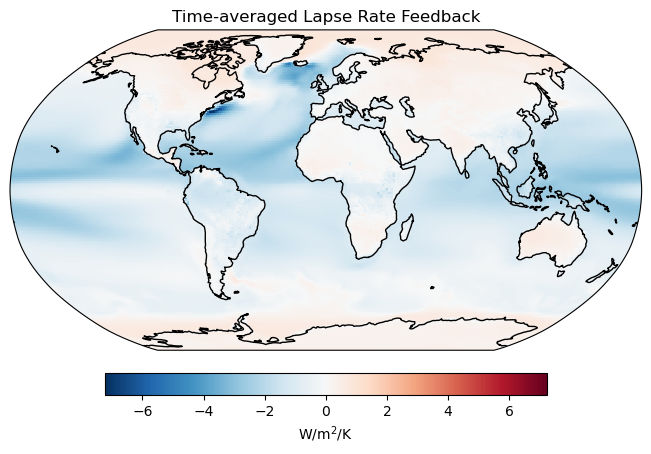

In [42]:
# Set a few variables
proj = ccrs.Robinson()

# Create figure and axis
fig, ax = plt.subplots(subplot_kw=dict(projection=proj),
                       layout="constrained")

# Plot surface albedo feedback & add coastlines
(lr.mean(dim="time")/Δts.mean(dim="time")).plot(ax=ax,transform=ccrs.PlateCarree(),
                         cbar_kwargs={"orientation": "horizontal", "shrink": 0.7,
                                      "label":"W/m$^2$/K"})
ax.coastlines()

# Add a title
ax.set_title("Time-averaged Lapse Rate Feedback")

plt.show()

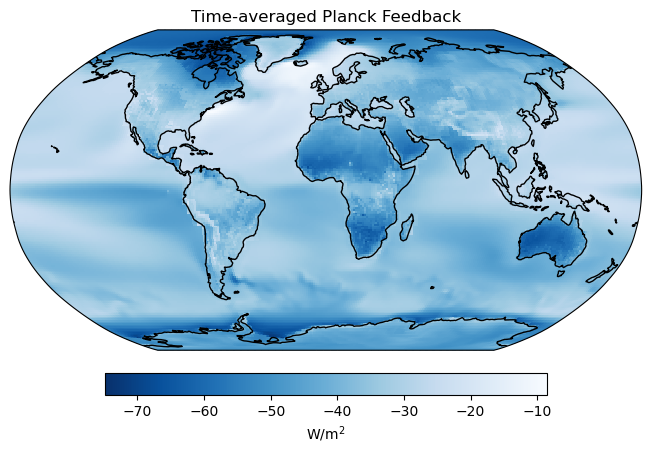

In [14]:
# Set a few variables
proj = ccrs.Robinson()

# Create figure and axis
fig, ax = plt.subplots(subplot_kw=dict(projection=proj),
                       layout="constrained")

# Plot surface albedo feedback & add coastlines
pl.mean(dim="time").plot(ax=ax,transform=ccrs.PlateCarree(),cmap="Blues_r",
                         cbar_kwargs={"orientation": "horizontal", "shrink": 0.7,
                                      "label":"W/m$^2$"})
ax.coastlines()

# Add a title
ax.set_title("Time-averaged Planck Feedback")

plt.show()

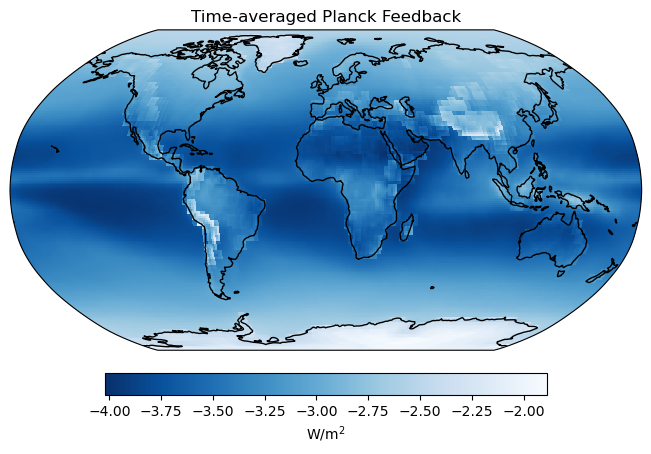

In [44]:
# Set a few variables
proj = ccrs.Robinson()

# Create figure and axis
fig, ax = plt.subplots(subplot_kw=dict(projection=proj),
                       layout="constrained")

# Plot surface albedo feedback & add coastlines
(pl.mean(dim="time")/Δts.mean(dim="time")).plot(
    ax=ax,transform=ccrs.PlateCarree(),cmap="Blues_r",
    cbar_kwargs={"orientation": "horizontal", "shrink": 0.7,"label":"W/m$^2$"}
)
ax.coastlines()

# Add a title
ax.set_title("Time-averaged Planck Feedback")

plt.show()

These results seem reasonable. The Planck feedback is often the feedback with the largest magnitude and scales nonlinearly with temperature change. The lapse rate feedback changes sign depending on the vertical structure of the atmosphere is usually positive (warming) at the poles and negative (cooling) in the tropics.

Let's get those global averages again!

In [56]:
# Output the time-averaged global temperature feedbacks
output = ("The global average lapse rate and Planck feedbacks are"+
          " {lr:.2f} and {pl:.2f} W/m\u00b2/K, respectively.")
print(output.format(lr=float(ck.spat_avg((lr.mean(dim="time")/Δts.mean(dim="time")
                                         ).expand_dims("time"))),
                   pl=float(ck.spat_avg((pl.mean(dim="time")/Δts.mean(dim="time")
                                        ).expand_dims("time")))))

The global average lapse rate and Planck feedbacks are -0.78 and -3.33 W/m²/K, respectively.


### Water vapor feedbacks

Here we use ClimKern to calculate the longwave and shortwave water vapor feedabcks. ClimKern has a single function that produces both called [`calc_q_feedbacks()`](https://tyfolino.github.io/climkern/climkern.html#climkern.calc_q_feedbacks). This function requires both the specific humidity and air temperature because ClimKern has to normalize the water vapor kernels to make them compatible with the specific humidity.

| Variable name | Description | Units | Notes |
| --- | --- | --- | --- |
|<i>hus</i> | The 4-dimensional specific humidity | $\frac{g}{g}$ or $\frac{g}{kg}$ | |
|<i>ta</i> | The 4-dimensional air temperature | K | |
|<i>ps</i> | The 3-dimensional surface pressure | Pa, mb, or hPa| |
|<i>trop_p</i> | The 3-dimensional tropopause height | Pa, mb, or hPa | <i>Optional</i> |

There is one more argument we can provide called `method`, which is simply a number 1-4. This corresponds to whether to use a fractional approximation for logarithms, use the logarithms explicitly, or use the linear change in water vapor concentration. See [here](https://tyfolino.github.io/climkern/climkern.html#climkern.calc_q_feedbacks) for complete descriptions. We will use method 3 which is to use the natural logarithm of specific humidity without doing a fractional approximation.

We will use the same tropopause height as before.

In [15]:
# Use ClimKern's water vapor feedback function
qlw,qsw = ck.calc_q_feedbacks(
    ctrl.hus,ctrl.ta,ctrl.ps,pert.hus,pert.ps,pert_trop=pert.trop_p,kern="ERA5",
    method=3
)

Let's take a look, starting with the longwave.

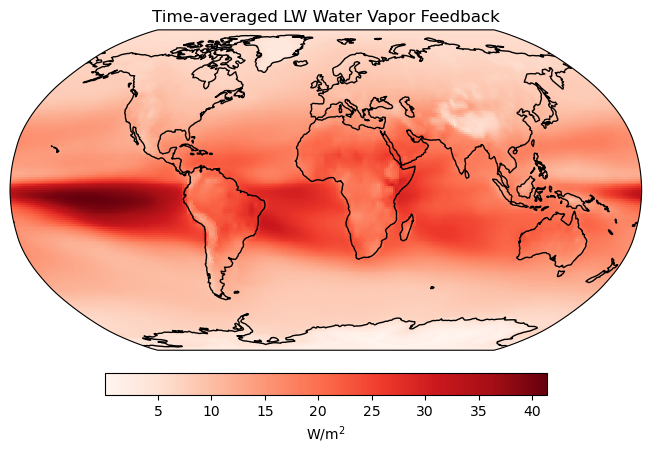

In [16]:
# Set a few variables
proj = ccrs.Robinson()

# Create figure and axis
fig, ax = plt.subplots(subplot_kw=dict(projection=proj),
                       layout="constrained")

# Plot the longwave water vapor feedback and add coastlines
qlw.mean(dim="time").plot(ax=ax,transform=ccrs.PlateCarree(),cmap="Reds",
                         cbar_kwargs={"orientation": "horizontal", "shrink": 0.7,
                                      "label":"W/m$^2$"})
ax.coastlines()

# Add a title
ax.set_title("Time-averaged LW Water Vapor Feedback")

plt.show()

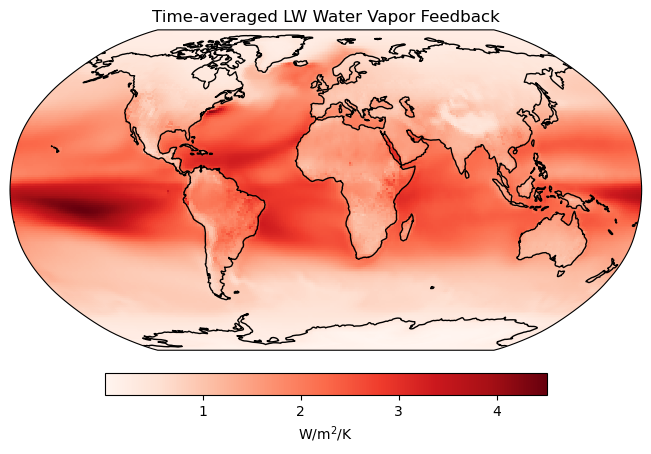

In [57]:
# Set a few variables
proj = ccrs.Robinson()

# Create figure and axis
fig, ax = plt.subplots(subplot_kw=dict(projection=proj),
                       layout="constrained")

# Plot the longwave water vapor feedback and add coastlines
(qlw.mean(dim="time")/Δts.mean(dim="time")).plot(
    ax=ax,transform=ccrs.PlateCarree(),cmap="Reds",
    cbar_kwargs={"orientation": "horizontal", "shrink": 0.7,
                 "label":"W/m$^2$/K"}
)
ax.coastlines()

# Add a title
ax.set_title("Time-averaged LW Water Vapor Feedback")

plt.show()

And now the shortwave...

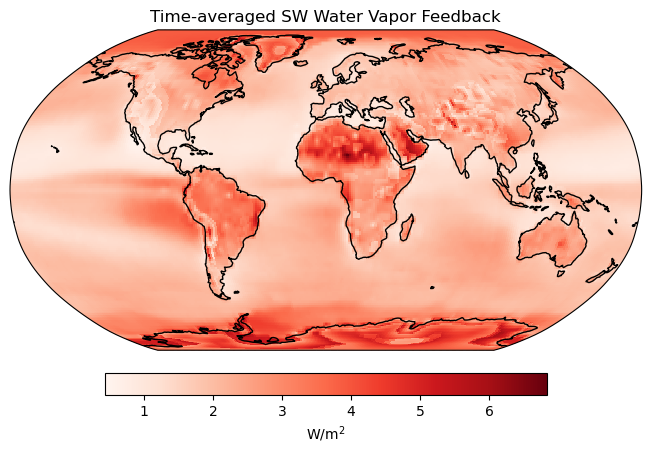

In [17]:
# Set a few variables
proj = ccrs.Robinson()

# Create figure and axis
fig, ax = plt.subplots(subplot_kw=dict(projection=proj),
                       layout="constrained")

# Plot the longwave water vapor feedback and add coastlines
qsw.mean(dim="time").plot(ax=ax,transform=ccrs.PlateCarree(),cmap="Reds",
                         cbar_kwargs={"orientation": "horizontal", "shrink": 0.7,
                                      "label":"W/m$^2$"})
ax.coastlines()

# Add a title
ax.set_title("Time-averaged SW Water Vapor Feedback")

plt.show()

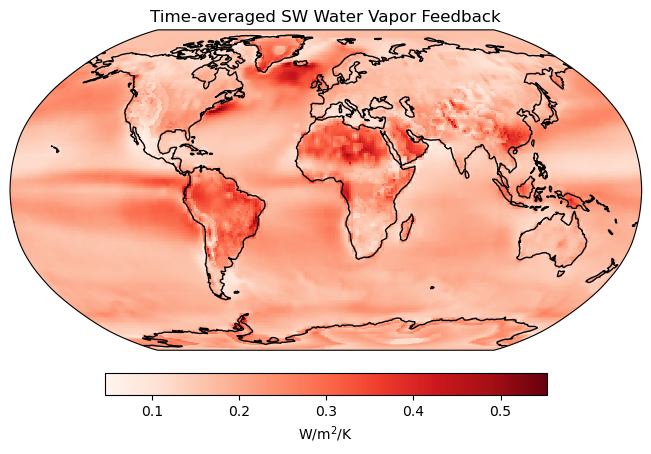

In [58]:
# Set a few variables
proj = ccrs.Robinson()

# Create figure and axis
fig, ax = plt.subplots(subplot_kw=dict(projection=proj),
                       layout="constrained")

# Plot the longwave water vapor feedback and add coastlines
(qsw.mean(dim="time")/Δts.mean(dim="time")).plot(
    ax=ax,transform=ccrs.PlateCarree(),cmap="Reds",
                         cbar_kwargs={"orientation": "horizontal", "shrink": 0.7,
                                      "label":"W/m$^2$/K"}
)
ax.coastlines()

# Add a title
ax.set_title("Time-averaged SW Water Vapor Feedback")

plt.show()

In [61]:
# Output the time-averaged global surface albedo feedback
output = ("The global average longwave and shortwave water vapor feedbacks are"+
          " {lw:.2f} and {sw:.2f} W/m\u00b2/K, respectively.")
print(output.format(lw=float(ck.spat_avg((qlw.mean(dim="time")/Δts.mean(dim="time")
                                         ).expand_dims("time"))),
                   sw=float(ck.spat_avg((qsw.mean(dim="time")/Δts.mean(dim="time")
                                        ).expand_dims("time")))))

The global average longwave and shortwave water vapor feedbacks are 1.59 and 0.19 W/m²/K, respectively.


### Cloud feedbacks

#### Download radiative forcing

It's time for cloud feedbacks. However, like anything to do with clouds, there are some complications. You ideally need the effective radiative forcing (ERF), which is a measure of radiative imbalance imposed by CO$_2$ in the absence of surface temperature change [Smith et al., 2020](https://doi.org/10.5194/acp-20-9591-2020). Thankfully, CESM2 radiative forcing for our scenarios is available on the Google cloud.

In [18]:
# Specify data location, open it
cat_url = "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"
col = intake.open_esm_datastore(cat_url)

# # Create a catalog of matching simulations
cat = col.search(activity_id="RFMIP",source_id="CESM2",experiment_id=["piClim-4xCO2",
                                                                      "piClim-control"],
                variable_id=["rlut","rsut","rsdt"])

# Convert to a dictionary of Xarray Datasets
ds_dict = cat.to_dataset_dict(zarr_kwargs={'consolidated': True})

# Assign Datasets to variables
rf_ctrl = ds_dict["RFMIP.NCAR.CESM2.piClim-control.Amon.gn"]
rf_pert = ds_dict["RFMIP.NCAR.CESM2.piClim-4xCO2.Amon.gn"]


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


<div class="admonition alert alert-info">
    <p class="admonition-title" style="font-weight:bold">Info</p>
    Your relevant information here!
</div>

Feel free to copy this around and edit or play around with yourself. Some other `admonitions` you can put in:

<div class="admonition alert alert-success">
    <p class="admonition-title" style="font-weight:bold">Success</p>
    We got this done after all!
</div>

<div class="admonition alert alert-warning">
    <p class="admonition-title" style="font-weight:bold">Warning</p>
    Be careful!
</div>

<div class="admonition alert alert-danger">
    <p class="admonition-title" style="font-weight:bold">Danger</p>
    Scary stuff be here.
</div>

We also suggest checking out Jupyter Book's [brief demonstration](https://jupyterbook.org/content/metadata.html#jupyter-cell-tags) on adding cell tags to your cells in Jupyter Notebook, Lab, or manually. Using these cell tags can allow you to [customize](https://jupyterbook.org/interactive/hiding.html) how your code content is displayed and even [demonstrate errors](https://jupyterbook.org/content/execute.html#dealing-with-code-that-raises-errors) without altogether crashing our loyal army of machines!

---